## Integration of SL1M and Caracal 

In [1]:
import sys
sys.path.append('../lib')

import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter as clock
import os

#SL1M
from sl1m.generic_solver import solve_L1_combinatorial, solve_MIP
from sl1m.problem_definition import Problem
import sl1m.tools.plot_tools as plot
import anymal_rbprm


import pybullet as p
import pybullet_data
import time
import sys
from anymal_lib import *
from functools import partial
import pinocchio

#caracal
import example_robot_data
import crocoddyl
from caracal.trajectory import SwingFootTrajectoryGenerator
from caracal.contact import ContactSchedule, ContactPhase

# %load_ext autoreload
# %autoreload 2

Import error: No module GLPK
Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-30
Import error: No module cvxpy


pybullet build time: Mar 26 2022 03:00:52


In [2]:
contact_names = ['LF_FOOT', 'LH_FOOT', 'RF_FOOT', 'RH_FOOT']

In [3]:
def get_potential_surfaces(configs, gait, all_surfaces):
    """
    Get the potential surfaces condidates for each moving foot.
    Here, all the surfaces are allocated for each foot, could be decreases using a guide path
    such as RBPRM.

    Args:
         - configs (list): the list of configurations.
         - gait (array nx4): gait matrix.
         - all_surfaces (list): list of surfaces.

    Returns:
        - (list): List of surface candidates for each moving foot.
    """
    surfaces_list = []
    for id, config in enumerate(configs):
        foot_surfaces = []
        stance_feet = np.nonzero(gait[id % len(gait)] == 1)[0]
        previous_swing_feet = np.nonzero(gait[(id - 1) % len(gait)] == 0)[0]
        moving_feet = stance_feet[np.in1d(stance_feet, previous_swing_feet, assume_unique=True)]
        for elt in moving_feet:
            foot_surfaces.append(all_surfaces)
        surfaces_list.append(foot_surfaces)

    return surfaces_list


def compute_com_positions(configs, pb):
    """
    Compute the CoM positions.

    Args:
        - configs (list): the list of configurations.
        - pb (Problem): sl1m problem.

    Returns:
        - (list): the list of CoM.
    """
    com_positions = []
    for phase in pb.phaseData:
        com = configs[phase.id][:3]
        com_positions.append(configs[phase.id][:3])

    return com_positions


def compute_effector_positions(configs, bvref, pb):
    """
    Compute the desired effector positions.

    Args:
        - configs (list): the list of configurations.
        - bvref (Array x3): the desired velocity in base frame.
        - pb (Problem): sl1m problem.

    Returns:
        - (list): Effector positions.
    """
    t_stance = T_gait / n_gait
    effector_positions = np.zeros((4, pb.n_phases, 2))

    for phase in pb.phaseData:
        for foot in phase.moving:
            rpy = pin.rpy.matrixToRpy(pin.Quaternion(np.array(configs[phase.id][3:7])).toRotationMatrix())
            yaw = rpy[2]  # Get yaw for the predicted configuration
            shoulders = np.zeros(2)
            # Compute heuristic position in horizontal frame
            rpy[2] = 0.  # Yaw = 0. in horizontal frame
            Rp = pin.rpy.rpyToMatrix(rpy)[:2, :2]
            heuristic = 0.5 * t_stance * Rp @ bvref[:2] + Rp @ offsets_feet[:2, foot]

            # Compute heuristic in world frame, rotation
            shoulders[0] = heuristic[0] * np.cos(yaw) - heuristic[1] * np.sin(yaw)
            shoulders[1] = heuristic[0] * np.sin(yaw) + heuristic[1] * np.cos(yaw)
            effector_positions[foot][phase.id] = np.array(configs[phase.id][:2] + shoulders)

    return effector_positions


def get_height_terrain(x, y):
    """ Get height and pitch angle of the terrain given x,y position. Hardcoded heightmap.

    Args:
        - x (float): x position.
        - y (float): y position.

    Returns:
        - (float): Z position.
        - (float): Pitch (rad).
    """
    slope_terrain = 0.4 / 2
    if x < 0.:
        return 0., 0.
    elif x > 2:
        return 0.4, 0.
    else:
        return slope_terrain * x, -np.arctan2(slope_terrain * x, x)

In [4]:
def create_sl1m_problem(q_init, q_goal):
    bvref = (q_goal-q_init)/(N_phase*1./n_gait)
    
    initial_config = np.zeros(7)  # Initial config
    initial_config[-1] = 1.
    initial_config[:3] = q_init

    # List of configurations in planned horizon, using the reference velocity.
    configs = []
    configs.append(initial_config.tolist())
    for i in range(1, N_phase):
        config = np.zeros(7)
        config[:3] = bvref * (T_gait / n_gait) * i + initial_config[:3]
        height, pitch = get_height_terrain(config[0], config[1])
        config[2] += height
        rpy = np.array([0., pitch, 0.])
        config[3:] = pin.Quaternion(pin.rpy.rpyToMatrix(rpy)).coeffs()
        configs.append(config.tolist())

    # List of rotation matrix
    R = [pin.XYZQUATToSE3(np.array(config)).rotation for config in configs]

    # Initian contacts
    q_tmp = np.zeros(3)
    q_tmp[:2] = q_init[:2] # Tmp vector, z = 0
    initial_contacts = [q_tmp + offsets_feet[:, foot] for foot in range(4)]

    surfaces = get_potential_surfaces(configs, GAIT, all_surfaces)

    pb = Problem(limb_names=limbs,
                 other_names=others,
                 constraint_paths=paths,
                 suffix_com=suffix_com,
                 suffix_feet=suffix_feet)
    pb.generate_problem(R, surfaces, GAIT, initial_contacts, configs[0][:3], com=USE_COM)

    # Generate costs
    com_positions = compute_com_positions(configs, pb)
    effector_positions = compute_effector_positions(configs, bvref, pb)
    costs = {
        "effector_positions": [1.0, effector_positions],
        "coms_xy": [0.5, com_positions],
        "coms_z": [0.05, com_positions],
        "step_size": [1.0, [0.2, 0.]]
    }
    return pb, surfaces, costs, initial_contacts, surfaces

#### Define environments

In [5]:
from sl1m_env import generate_stair_small, generate_stair_full

#1. Standard environment
# stairHeight = 0.1
# scene = generate_stair_small(stairHeight, side_margin=0.)
# env_name = '../env/urdf/full_stair_small.urdf'
# N_STEP = 7

#3. Higher stairs (height = 0.15)
stairHeight = 0.15
scene = generate_stair_small(stairHeight, side_margin=0.)
env_name = '../env/urdf/full_stair_small_0.15.urdf'
N_STEP = 8

#4. Higher stairs (height = 0.2)
# stairHeight = 0.2
# scene = generate_stair_small(stairHeight, side_margin=0.)
# env_name = '../env/urdf/full_stair_small_0.2.urdf'
# N_STEP = 11

#2. More Stairs
# stairHeight = 0.1
# scene = generate_stair_full(stairHeight, side_margin=0.)
# env_name = '../env/urdf/full_stair.urdf'
# N_STEP = 11
#5. Longer stairs (low priority)

#### Defining the (SL1M) problem

In [6]:
# Problem definition
paths = [os.path.join(os.path.dirname(anymal_rbprm.__file__), "../../../..", "share/anymal-rbprm/com_inequalities/feet_quasi_flat/anymal_"),
         os.path.join(os.path.dirname(anymal_rbprm.__file__), "../../../..", "share/anymal-rbprm/relative_effector_positions/anymal_")]
suffix_com = "_effector_frame_quasi_static_reduced.obj"
limbs = ['LFleg', 'RFleg', 'LHleg', 'RHleg']
others = ['LF_ADAPTER_TO_FOOT', 'RF_ADAPTER_TO_FOOT', 'LH_ADAPTER_TO_FOOT', 'RH_ADAPTER_TO_FOOT']
suffix_feet = "_reduced.obj"

# Order : [LF, RF, LH, RH]
GAITS = {}
GAITS["walk"] = np.array([[0., 1., 1., 1.], [1., 0., 1., 1.], [1., 1., 0., 1.], [1., 1., 1., 0.]])
GAITS["trot"] = np.array([[1., 0., 1., 0.], [0., 1., 0., 1.]])
# Number of phase in one gait
N_GAIT = {}
N_GAIT["walk"] = 4
N_GAIT["trot"] = 2

# Parameters of the optimisation
USE_COM = True
USE_SL1M = False
gait = "trot"  # type of gait chosen
n_gait = N_GAIT[gait]  # Number of phase in the gait
GAIT = GAITS[gait]
T_gait = 1. # Period of the gait
N_phase = N_STEP * n_gait  # Global number of phase



# List of surfaces following the format :
# vertices = array([[x0, ... , xn],
#                  [y0, ... , yn],
#                  [z0, ... , zn]])
all_surfaces = []
for sf in scene:
    all_surfaces.append(sf[0])

# Order : [LF, RF, LH, RH]
offsets_feet = np.array([[0.37, 0.37, -0.37, -0.37], [0.2, -0.2, 0.2, -0.2], [0., 0., 0., 0.]])

In [11]:
#### Generate random q_init and q_goal
#Vary in y direction only
M = 300
x_init = (np.random.rand(M)-0.5)*0.2 - 0.3 
y_init = (np.random.rand(M)-0.5)*0.6 + 0.22 
y_final = (np.random.rand(M)-0.5)*0.3 + 0.22  #-0.25 to 0.7

In [12]:
#### Input Parameters 
tic = time.time()
total_data = []
for i in range(M):
    print(i)
    q_init = np.array([x_init[i], y_init[i], 0.47])  # Initial Position
#     q_final = np.array([1.8, y_final[i], 0.47 + 0.2]) 
    q_final = np.array([np.mean(scene[-1][0][0,:])+0.2, y_final[i], 0.47 + scene[-1][0][-1,-1]]) 


    #### Solve SL1M

    pb, surfaces, costs, initial_contacts, surfaces = create_sl1m_problem(q_init, q_final)

    if USE_SL1M:
        result = solve_L1_combinatorial(pb, surfaces,costs=costs,  com=USE_COM)
    else:
        result = solve_MIP(pb, costs=costs, com=USE_COM)
    
    if not result.success:
        continue
    #### Save data (for caracal)

    lf_poses = result.all_feet_pos[0]
    rf_poses = result.all_feet_pos[1]
    lh_poses = result.all_feet_pos[2]
    rh_poses = result.all_feet_pos[3]

    data = dict()
    data['q_init'] = q_init
    data['q_final'] = q_final
    data['init_contacts'] = initial_contacts
    data['lf_poses'] = lf_poses
    data['rf_poses'] = rf_poses
    data['lh_poses'] = lh_poses
    data['rh_poses'] = rh_poses
    data['scene'] = scene
    data['surfaces'] = surfaces
    data['result'] = result
    data['env_name'] = env_name
    data['stairHeight']=stairHeight
    data['N_STEP'] = N_STEP
    total_data.append(data)
#np.save('data/plan_stairs_small_tight_smallstep', total_data)

np.save('data/more_closer_'+env_name[12:-5], total_data)

toc = time.time()
print('Planning takes {} s'.format(toc-tic))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### Plot Result

In [30]:
total_data = np.load('data/'+env_name[12:-5]+'.npy', allow_pickle=True)

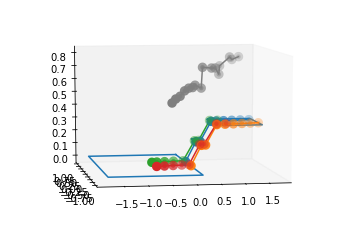

[1.32582707 0.28567801 0.79034899]


In [23]:
#%matplotlib qt
idx = 0
result = total_data[idx]['result']
ax = plot.draw_scene(scene)
if(result.success):
    plot.plot_planner_result(result.all_feet_pos, coms=result.coms, ax=ax, show=True)
else:
    plt.show()

print(result.coms[-1])

data = total_data[idx]
lf_poses = data['lf_poses'] 
rf_poses = data['rf_poses'] 
lh_poses = data['lh_poses']
rh_poses = data['rh_poses']

## Pybullet Visualizations

#### Setup Pybullet

In [12]:
from pb_utils.visualize import set_q, vis_traj, create_primitives

In [13]:
p.connect(p.GUI)
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [14]:
p.resetSimulation()

p.loadURDF('plane.urdf')

#### Create the foot objects
_,_,rh_id = create_primitives(radius=0.03, rgbaColor=[1.,0,0,1.])
_,_,rf_id = create_primitives(radius=0.03, rgbaColor=[0.,1,0,1.])
_,_,lh_id = create_primitives(radius=0.03, rgbaColor=[0.,0,1.,1.])
_,_,lf_id = create_primitives(radius=0.03, rgbaColor=[1.,0,1.,1.])

#### Plot scene
for i in range(len(scene)):
    surf = np.array(scene[i][0]).T
    origin = np.mean(surf, axis=0)
    length_x = np.abs(surf[0,0]-surf[2,0]) + 0.
    length_y = np.abs(surf[0,1]-surf[2,1]) + 0.
    length_z = 0.01
    _,_,box_id = create_primitives(p.GEOM_BOX, halfExtents=[length_x/2, length_y/2, length_z/2])
    p.resetBasePositionAndOrientation(box_id, origin, (0,0,0,1))

In [15]:
p.loadURDF(env_name)

8

#### Plot foot sequence

In [16]:
p.resetBasePositionAndOrientation(rh_id, initial_contacts[0], (0,0,0,1))
p.resetBasePositionAndOrientation(rf_id, initial_contacts[1], (0,0,0,1))
p.resetBasePositionAndOrientation(lh_id, initial_contacts[2], (0,0,0,1))
p.resetBasePositionAndOrientation(lf_id, initial_contacts[3], (0,0,0,1))

#### Visualize the foot poses

In [18]:
N = len(rh_poses)

for i in range(N):
    if rh_poses[i] is not None:
        p.resetBasePositionAndOrientation(rh_id, rh_poses[i], (0,0,0,1))
    if rf_poses[i] is not None:
        p.resetBasePositionAndOrientation(rf_id, rf_poses[i], (0,0,0,1))
    if lh_poses[i] is not None:
        p.resetBasePositionAndOrientation(lh_id, lh_poses[i], (0,0,0,1))
    if lf_poses[i] is not None:
        p.resetBasePositionAndOrientation(lf_id, lf_poses[i], (0,0,0,1))
#     usr = input()
    time.sleep(0.5)

KeyboardInterrupt: 